# Lesson 4

In [62]:
# Put these at the top of every notebook to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import os
from glob import glob
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from fastai import fastai
from fastai.fastai import transforms
from fastai.fastai import conv_learner
from fastai.fastai import model
from fastai.fastai import dataset
from fastai.fastai import sgdr
from fastai.fastai import plots as faplots
from fastai.fastai import metrics
from fastai.fastai import structured
from fastai.fastai import column_data
from torchvision.models import resnet18, resnet34
from fastai.fastai.torch_imports import resnext101_64
import torch

## 00:00:24 - Fast.AI student article recap

* [Improving the way we work with learning rate](https://techburst.io/improving-the-way-we-work-with-learning-rate-5e99554f163b?gi=79e0118def63)
* [The Cyclical Learning Rate technique](http://teleported.in/posts/cyclic-learning-rate/)
* [Exploring Stochastic Gradient Descent with Restarts (SGDR)](https://medium.com/38th-street-studios/exploring-stochastic-gradient-descent-with-restarts-sgdr-fa206c38a74e)
* [Transfer Learning using differential learning rates](https://towardsdatascience.com/transfer-learning-using-differential-learning-rates-638455797f00)
* [Getting Computers To See Better Than Humans](https://medium.com/@ArjunRajkumar/getting-computers-to-see-better-than-humans-346d96634f73)

## 00:03:30 - Lessons recap and plan

* Lesson 1, 2 and 3 = CNN image intro
* Lesson 4 = Structured data, language RNN and collaborative filtering.
* Lesson 5 = SGD and loss function + collaborative filtering in depth.

## 00:04:59 - Dropout

* Activation is just a number, calculated using some parameters.
* Firstly, examine the precomputed `ConvLearner` object below, which only includes the last, fully-connected, layers of the model:

In [8]:
PATH = 'data/dogbreed/'
arch = resnet34
sz = 224
bs = 64

In [12]:
tfms = transforms.tfms_from_model(arch, sz, aug_tfms=transforms.transforms_side_on, max_zoom=1.1)
data = dataset.ImageClassifierData.from_csv(
    PATH, 'train', f'{PATH}labels.csv',
    test_name='test', suffix='.jpg', tfms=tfms, bs=bs)
learn = conv_learner.ConvLearner.pretrained(arch, data, ps=0.5, precompute=True)

In [13]:
learn

Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.5)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=120, bias=True)
  (7): LogSoftmax()
)

* Note the following layers:
  * `BatchNorm1d` - covered in the last lesson.
  * `Linear` - matrix multiplier.
    * A matrix which is size `(1024, 512)`.
    * Takes in `1024` activations and returns `512` activations.
  * `ReLU` - replaces negatives with 0.
  * `LogSoftmax` - put the previous linear layers activations and return log probability.
  
* `Dropout` with p=0.5, simply means: delete 50% of the activations at random:

<img src="https://i.gyazo.com/d8d5cd5d62faca8eb70554502dc8f189.gif" width="400px">

* Forces the model not to overfit:
  * If one activation has learned about an "exact" dog breed, then when it's removed, it's going to hurt the loss.
  * Model has to find a fit that works, even without certain activations.

* Critical in making modern deep learning work.
  * Solved the problem of generalisation.
  
### 00:13:24 - Audience questions

* Question 1: Do you have to do anything to accomodate for the fact you're throwing away activations?
* Answer 1: All handled behind the scenes by PyTorch. If you set `p=0.5`, PyTorch will double the number of activations to account for the deleted ones.

***

* For minor precision reasons, we take the log of the softmax on the final layer, which means we need to convert it with `exp`.
* You can pass in `ps=0.5` to change the Dropout on the added layers, not on the pretrained layers.
* Setting `ps=0` will remove Dropout all together:

In [14]:
conv_learner.ConvLearner.pretrained(arch, data, ps=0, precompute=True)

Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Linear(in_features=1024, out_features=512, bias=True)
  (2): ReLU()
  (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (4): Linear(in_features=512, out_features=120, bias=True)
  (5): LogSoftmax()
)

* Can also pass `xtra_fc=[<list of extra FC layers>]` as a list of additional fully-connected layers. Empty list would exclude all but the final layer:

In [15]:
conv_learner.ConvLearner.pretrained(arch, data, ps=0, precompute=True, xtra_fc=[])

Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Linear(in_features=1024, out_features=120, bias=True)
  (2): LogSoftmax()
)

### 00:17:54 - Audience questions

* Question 1: What sort of `p` should we use by default?
* Answer 1: Fast.ai defaults to `.25` for 2nd layer and `0.5` for last layer - works well for most things.
  * Bump it up if overfitting.
  * Lower if underfitting.
  * Bigger models will generally need more dropout.
  
* Question 2: Setting `p=0.5` is that 50%?
* Answer 2: Yes.

* Question 3: How can you determine if you're overfitting?
* Answer 3: Yes, the training error will be lower than the validation.
  * Overfitting isn't always a bad thing, as long as your validation loss is going down.
  
* Question 4: Setting `p` is probabilty of deleting activations, not of keeping activations?
* Answer 4: Yes

* Question 5: Why does the average activation matter?
* Answer 5: If you deleted activations, it will have a knock on effect to later calculations. Your goal is to delete activations, without changing the meaning of future activations.

* Question 6: Why are you using a linear activation for an earlier activation?
* Answer 6: It's the only choice you have based on what previous layers return.

* Question 7: Can you have different dropout by layer?
* Answer 7: Pass in array to `ps` argument:

In [18]:
conv_learner.ConvLearner.pretrained(arch, data, ps=[0.25, 0.125], precompute=True)

Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.125)
  (6): Linear(in_features=512, out_features=120, bias=True)
  (7): LogSoftmax()
)

  * J doesn't have good intuition for when to use different values off Dropout on final layers.

* Question 8: Why measure the loss, instead of accuracy going up?
* Answer 8: Because loss is actually being used by SGD so it's good to see it.

* Question 9: Does Dropout impact the learning rate?
* Answer 9: In theory, but not much in practise.

## 00:25:04 - Structure data problem (Rossman Kaggle competition)

* Main dataset provides the following info: at a particular store, how much did they sell?
* See [this](lesson4-rossman-data-preprocessing.ipynb) notebook for data preprocessing.

### 00:26:58 - Preparing features

* Winner from the competition came up with useful columns.
* List of things we're going to treat as "categorial variables"
  * Could treat year, month and day as continous, but categorical usually works better in practise.
* If it's categorical in the data, you'll have to treat it the same in the model. If continuous, you get to pick.

In [28]:
PATH = 'data/rossman/'

In [29]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

In [30]:
contin_vars = [
    'CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
    'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h',
    'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
    'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday'
]

In [31]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

* Cardinality refers to number of items in a category: "cardinality of days of week is 7".

### 00:30:59 - Audience questions

* Q1: Heuristic for when to bin continuous variables?
* A1: Jeremy doesn't bin continuous variables (process of putting continuous data into categorical "bins"), though apparently it may be useful in certain cases.

* Q2: If you're using year as a category, what happens if it's never seen that year?
* A2: It'll be treated as an "unknown" year: unknown then just becomes another category.

* Q3: If our training dataset doesn't have a category, and test has unknown, how does it work?
* A3: It'll probably have learned a way to predict unknowns or will just have a random vector.

### 00:33:17 - Preparing features cont

* Can see we have 844k rows:

In [32]:
n = len(joined); n

844338

* Convert to category using Pandas:
  * Note that PyTorch expects a float32, which is why the continuous variables are being converted.

In [33]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()
for v in contin_vars: joined[v] = joined[v].astype('float32')
    
dep = 'Sales'

joined = joined[cat_vars + contin_vars + [dep, 'Date']]

* Run on a sample:

In [34]:
idxs = dataset.get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index('Date')
samp_size = len(joined_samp); samp_size

150000

* Date has some booleans, some integers and some letters that Pandas displays as strings:

In [35]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-16,257,2,2015,6,16,False,24,0,a,a,...,18.0,8.0,6.0,63.0,71.0,22.0,0.0,1.0,0.0,5934
2013-10-30,4,3,2013,10,30,False,24,0,c,c,...,29.0,16.0,2.0,74.0,66.0,27.0,-56.0,0.0,0.0,7800


* Fast.ai library includes a function called `proc_df`:
  * pulls out dependent variables (in this example `Sales`).
  * Scales dataset to between -1 and 1 by subtracting the mean and dividing by the standard deviation.

In [36]:
df, y, nas, mapper = structured.proc_df(joined_samp, 'Sales', do_scale=True)

* Also returns a special object which includes the mean and std for subtracting and dividing the test set.

In [37]:
mapper

DataFrameMapper(default=False, df_out=False,
        features=[(['CompetitionDistance'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['Max_TemperatureC'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['Mean_TemperatureC'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['Min_TemperatureC'], StandardScaler(co...rue, with_std=True)), (['CloudCover_na'], StandardScaler(copy=True, with_mean=True, with_std=True))],
        input_df=False, sparse=False)

* Also handles missing values by setting them to 0 for categorical, or replacing with median variable for continues.

In [38]:
nas

{'CompetitionDistance': 2320.0, 'CloudCover': 6.0}

In [41]:
y_log = np.log(y)

In [42]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-16,257,2,3,6,16,1,25,1,1,1,...,-0.651394,0.266629,-0.194358,0.487305,-0.525077,1.109608,1.115768,-0.489079,-0.050661,-0.294389
2013-10-30,4,3,1,10,30,1,25,1,3,3,...,0.700532,-2.197401,0.769911,-0.026011,-0.363976,-0.602128,-0.896244,-0.489079,-0.050661,-0.294389


### 00:38:36 - Selecting validation sets with timeseries data

* Cross-val should not be random with time series data.
* Generally use the most recent data for holdout set, like real life.
  * Could take the last 25% of rows, as follows:

In [43]:
train_ratio = 0.75
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

* A better option, for this case, would be to get the same time period as the test set:

In [44]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014, 8, 1)))

* Rachel posted an article on creating validations set [here](http://www.fast.ai/2017/11/13/validation-sets/).

### 00:39:35 - Understand metric for evaluating model

* Kaggle use root mean squared percent error as the evaluation metric for Rossman competition: $\text{RMSPE }=\sqrt{\frac{1}{n} \sum\limits_{i=1}^{n}{(\frac{y_i-\hat{y}_i}{y_i})}^2}$
  * Since we know that $log(\frac{a}{b})=log(a)-log(b)$:
  
  ```
  >> math.log(10/5)
  >> 0.6931471805599453

  >> math.log(10) - math.log(5)
  >> 0.6931471805599456
  ```
  * If you take the log of the data, the root mean squared error will actually get you the root mean squared percent error. You can inverse the results with `exp`.

In [45]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred)) / targ
    return math.sqrt((pct_var ** 2).mean())

max_log_y = np.max(y1)
y_range = (0, max_log_y * 1.2)

* Create a `ModelData` object using the data frame with `ColumnarModelData.from_data_frame`

In [46]:
md = column_data.ColumnarModelData.from_data_frame(PATH, val_idx, df, y_log, cat_flds=cat_vars, bs=128)

  * `PATH` - path where you want to store any temp files or models etc.
  * `val_idx` - list of rows to put in validation set.
  * `df` - DataFrame.
  * `yl` - dependent variables.
  * `cat_flds` - which fields should be considered categorical?
  * `bs` - batch size.

* Get number of levels of each categorical var:

In [23]:
cat_sz = [
    (c, len(joined_samp[c].cat.categories) + 1) for c in cat_vars]

In [24]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

## 00:45:39 - Embeddings

* Firstly continuous variables:
  * Bunch of floating point numbers in vector, for example one with 20 columns. `(1, 20)`
  * Then put through a matrix product with anther matrix with a matching number of rows to the vectors columns: `(20, 100)`
  * That returns a vector with 100 columns: `(1, 100)`, which are then put through a relu activation.
  * Then put through a relu activations.
  * Lasly, put through another matrix multiplication, of `(100, 1)` which returns a single value: `(1, 1)`.
* Aside from adding dropout and stuff, there aren't many interesting architectural choices when using fully-connected layers.

* Categorical:
  * For each set of categorical vars (eg day of week): Create another matrix with n columns and a row for each category.
    * Called an "embedding matrix".
  * Then, at training time, pull out the appropriate row and concat to continuous variables.
  * Basically, it's a way to convert categorical variables into continuous numbers.
  * Side effect of the embedding is that they're sometimes human interpretable and can be quite interesting.

### 00:55:56 - Audience questions

* Q1: Is there a heuristic for selecting the size of embeddings?
* A1: Half the cardinality of category (eg `8//2=4)` fields for day of week), as long as it's no greater than 50.

In [48]:
emb_szs = [(c, min(50, (c+1)//2)) for _, c in cat_sz]

In [49]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

* Q2: Would you always build embedding matrix for each categorical feature?
* A2: Yes.

* Q3: Besides random initialisation, is there another way to init embedding?
* A3: You could either use random, or find another pretrained embedding matrix. Perhaps one has been trained to predict similar products.

* Q4: Why not just use a one-hot encoded values instead of embedding?
* A4: You could just pass in 7 vars, 6 of them 0 and 1 of them 1. Problem: concept of Sunday, could only be associated with a single floating point number. With embeddings, it becomes a concept in 4 dimensional space, which can give them "rich semantic concepts".
  * Examples:
    * weekends may have a different behaviour, causing some number to be higher.
    * one column may represent certain products selling better on certain days.

### 01:07:14 - Dealing with dates

* Fast.ai function called `add_datepart` that takes a dataframe and a datefield column name.
  * It then removes the date and replaces it with categorical variables about the date: day of week, is it end of quarter, start of month etc.

In [52]:
date_df = pd.DataFrame({'Date': [datetime.datetime(2017, 3, 1), datetime.datetime(2017, 3, 2)]})

In [53]:
date_df.head()

,Date
0,2017-03-01
1,2017-03-02


In [54]:
structured.add_datepart(date_df, 'Date', drop=False)

In [55]:
date_df.head()

,Date,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2017-03-01,2017,3,9,1,2,60,False,True,False,False,False,False,1488326400
1,2017-03-02,2017,3,9,2,3,61,False,False,False,False,False,False,1488412800


### 01:10:05 - Training model

In [64]:
m = md.get_learner(
    emb_szs=emb_szs,
    n_cont=len(df.columns)-len(cat_vars),
    emb_drop=0.04,
    out_sz=1,
    szs=[1000, 500],
    drops=[0.001, 0.01],
    y_range=y_range
)

lr = 1e-3

  * `emb_szs` - embedding matrix sizes.
  * `n_cont` - number of continous variables.
  * `emb_drop` - how much dropout to use.
  * `out_sz` - output size.
  * `szs` - how many activations to use.
  * `drops` - how much dropout to use in the later layers.

In [58]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

* Can now do the standard stuff, like getting the learning rate:

In [59]:
m.lr_find()

 66%|██████▌   | 735/1120 [00:50<00:26, 14.70it/s, loss=0.329] 

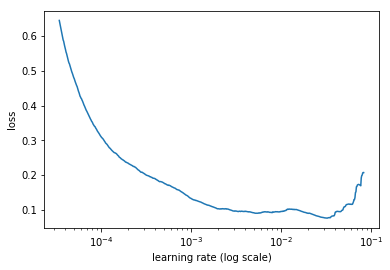

In [60]:
m.sched.plot(100)

In [ ]:
lr = 1e-3

* Note that we're passing in metrics to be printed at the end of each epoch.

In [65]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.026518   0.022992   0.159085  
    1      0.018788   0.029464   0.152526                       
    2      0.017182   0.021571   0.13363                        



[0.021571023, 0.13362987312569344]

In [66]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.012154   0.01711    0.121186  
    1      0.011085   0.018633   0.12522                        
    2      0.010783   0.01749    0.121782                       



[0.017490305, 0.1217821107997797]

* The winners of the Kaggle competition did a lot more feature engineering. Generally deep learning approaches require somewhat less feature engineering.

### 01:15:02 - Audience questions

* Q1: Are we using time series in any of the fits?
* A1: Yes, by converting the date data into categorical variables.

* Q2: In the earlier CNNs we didn't pass data during the fit. Is that the case here?
* A2: We aren't passing in anything at fit time. The model that we build depends on the data, hence the learner being returned from the data: `m.get_learner`.

* Q3: Do I just need to figure out what to put into categorical variables / embeddings on my own dataset?
* A3: Steps for your own dataset:
  1. Put your data in a Pandas dataframe and list the categorical variables and continuous variables.
  2. Figure out which rows go in the validation dataset.
  3. Call `ColumnarModelData.from_data_frame(PATH, val_idx, df, yl, cat_flds=cat_vars, bs=128`, passing in your data.
  4. Create your list of how big your embedding matrices should be.
  5. Call  `get_learner` to get your learner.
  6. Call `fit` to fit the data.
  
* Q4: How can data augmentation be used here?
* A4: Data augmentation doesn't really exist with structured data yet.

## 01:23:34 - Natural Language Processing

* NLP is the most up-and-coming area of Deep Learning, about 2-3 years behind image classification.
* Language modelling:
  * build a model where given a few words of a sentence, can you predict the next word?
  * [Swiftkey](https://swiftkey.com/en) used DL for it.
* Language models can be used in classification tasks (like sentiment analysis).

###  01:31:35 - Audience questions

* Q1: Why not just learn the classification model without a language model?
* A1: We already know that transfer learning is useful. Also, the IMDB reviews are sometimes quite large and it's too much to try to learn English *and* how to predict sentiment.

* Q2: Is this similar to the [char-rnn](https://github.com/karpathy/char-rnn)?
* A2: Yes, except language models usually work at a word level, rather than a character level: they tend to be more powerful.

* Q3: To what extent are these generated words and sentences seen before or randomly created?
* A3: All the words must have been seen before. The sentences generated would be similar but not exact to what's generated.

### 01:36:37 - New imports

* [Torchtext](https://github.com/pytorch/text) - Pytorch's NLP library.

In [69]:
import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

* Some new text-specific fast.ai stuff:

In [70]:
from fastai.fastai.rnn_reg import *
from fastai.fastai.rnn_train import *
from fastai.fastai.nlp import *
from fastai.fastai.lm_rnn import *

import dill as pickle

* Going to be working with [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/).
  * Very well studied in academia.
  * 50k reviews.
* Going to start by creating a language model first.

In [71]:
PATH = 'data/aclImdb/'

TRN_PATH = 'train/all/'
VAL_PATH = 'test/all/'

TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

In [79]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz --directory-prefix=data

--2018-04-17 15:26:58--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu... 171.64.68.10
Connecting to ai.stanford.edu|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘data/aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  3.44MB/s    in 34s     

2018-04-17 15:27:33 (2.37 MB/s) - ‘data/aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [80]:
!tar -xzf data/aclImdb_v1.tar.gz -C data

### 01:37:54 - Analysing IMDB dataset

In [84]:
!ls {PATH}

README     imdb.vocab imdbEr.txt test       train
